<a href="https://colab.research.google.com/github/sahar7888/NLP_LLM_Projects/blob/main/NLP_Fine_tuning_Simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.7 MB/s eta 0:00:00


In [3]:
#Packages
#%% packages
from datasets import load_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from transformers import AutoModel, DistilBertTokenizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier


In [4]:
yelp = load_dataset('yelp_review_full')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
yelp

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

# EDA

In [33]:
#%% create dataset
train_ds = yelp['train']
train_ds[0]

{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [34]:
train_ds.features

{'label': ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

In [35]:
# %% imbalance of dataset
val_count = pd.DataFrame(train_ds['label']).value_counts()

<Axes: ylabel='count'>

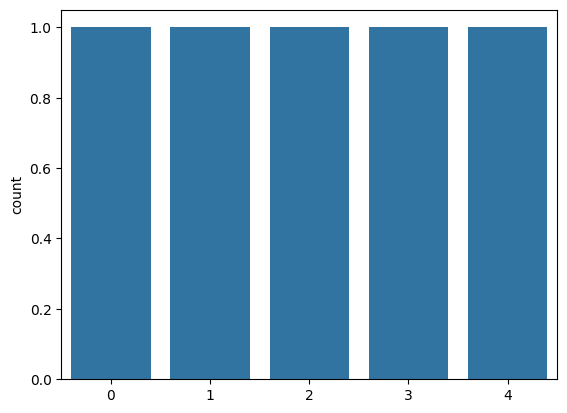

In [36]:
sns.countplot(val_count.tolist())

In [7]:
#%% create dataset
train_ds = yelp['train'].select(range(1000))

<Axes: xlabel='label', ylabel='review_length'>

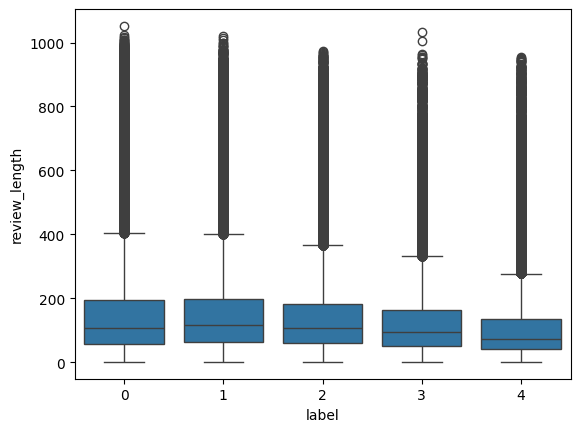

In [37]:
# %% understanding the texts
# count of words per review / per class
df_review_len_label = pd.DataFrame({'review_length': [len(s.split()) for s in train_ds['text']], 'label': train_ds['label']})
sns.boxplot(x='label', y='review_length', data=df_review_len_label)

In [9]:
#%% Model and Tokenizer
model_name = 'distilbert-base-uncased'
device = 'cpu'

In [10]:
model = AutoModel.from_pretrained(model_name).to(device)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
#Ex:
# %% Tokenizer
text = 'Hello, this is a sample sentence!'

encoded_text = tokenizer(text, return_tensors='pt')
encoded_text

{'input_ids': tensor([[ 101, 7592, 1010, 2023, 2003, 1037, 7099, 6251,  999,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [14]:
# %% Tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'][0])
tokens

['[CLS]', 'hello', ',', 'this', 'is', 'a', 'sample', 'sentence', '!', '[SEP]']

In [15]:
# %%
tokenizer.convert_tokens_to_string(tokens)

'[CLS] hello , this is a sample sentence ! [SEP]'

In [16]:
# %% how large is the vocabulary?
tokenizer.vocab_size

30522

In [17]:
# %% Max context length
max_context_length = tokenizer.model_max_length
max_context_length

512

In [18]:
# %% Function for tokenization
def tokenize_text(batch):
  # padding...texts are filled with zeros based to longest example
    # truncation...texts are cut off after max_context_length
    return tokenizer(batch['text'], padding='max_length', truncation=True)


In [19]:
yelp_encodings = train_ds.map(tokenize_text, batched=True, batch_size=128)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [20]:
yelp_encodings.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])  # encodings need to be converted to torch tensors

In [22]:
def get_last_hidden_state(batch):
    inputs = {k: v for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        # [:, 0] refers to CLS token for complete sentence representation
    return {'hidden_state': last_hidden_state[:, 0]}

In [23]:
yelp_hidden_states = yelp_encodings.map(get_last_hidden_state, batched=True, batch_size=128)  # will have additional column 'hidden_state

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [24]:
yelp_hidden_states

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 1000
})

In [26]:
import joblib
joblib.dump(yelp_hidden_states, 'yelp_hidden_states.joblib')

['yelp_hidden_states.joblib']

In [27]:
cutoff = 800
X_train = np.array(yelp_hidden_states['hidden_state'][:cutoff])
y_train = np.array(yelp_hidden_states['label'][:cutoff])
X_test = np.array(yelp_hidden_states['hidden_state'][cutoff: ])
y_test = np.array(yelp_hidden_states['label'][cutoff: ])
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (800, 768), y_train.shape: (800,)
X_test.shape: (200, 768), y_test.shape: (200,)


In [28]:

# %% SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)

0.395

In [29]:
# %% Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.425

In [30]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)
# %%

0.33

In [31]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
dummy_model.score(X_test, y_test)

0.165